# Hi Storm Snackers!

## My research objectives and workflow

1. Run EnKF simulations using ARPS NWP model and save output as HDF files

2. Use saved 4D kinematic and thermodynamic fields to analyze storm-scale dynamics

3. Efficient processing and visualization of subset datasets

4. Cold pools <-> lightning --> papers (hopefully)!

<p>
    <center><img style="float:center;" src="logos/cp_KTLX_only.gif"  width="800"/></center>
</p>

***

## What is scalibility and why should I care?

#### <span style="color:blue"> A system is considered scalable when it doesn’t need to be redesigned to maintain effective performance during or after a steep increase in workload.</span>

#### `Think of the strain on software/hardware architecture when data storage increases, algorithms are complex etc.`

#### <span style="color:red"> Umm, I thought python would handle it? </span>

> Turns out that python is not so great at it...

<center><a href="https://imgflip.com/i/416iip"><img src="https://i.imgflip.com/416iip.jpg" title="made at imgflip.com"/></a><div><a href="https://imgflip.com/memegenerator"></a></div></center>

***

## Enter scalable "post-processing" analysis software

### Today we plan to use these amazing python libraries 

<p>
    <img style="float:center;" src="logos/dask.svg"  width="400"/>
    <img style="float:center;" src="logos/xarray.png" width="400"/>
</p>

<p>
    <img style="float:center;" src="logos/zarr.png" width="200"/>
    <img style="float:center;" src="logos/numba.svg" width="400"/>
</p>


In [42]:
import os
import sys

import cf_xarray
import numpy as np

module_path = os.path.abspath(os.path.join("."))
if module_path not in sys.path:
    sys.path.append(module_path)

from arps_read_xarray import arps_read_xarray_cf
from pyCRMtools.modules import utils
import matplotlib.pyplot as plt

# import sys
# sys.path.append('/depot/rtanama/users/sharm261/May_19_2013_all_stuff/python_scripts_ARPS_May_19_2013/arps_xarray_based_python_analysis_scripts/')

# set rcparams
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20

In [43]:
#Disable a couple of warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)

### Setup: HPC (Purdue RCAC Rice cluster) / dask_jobqueue

> Dask is a Python-based Big Data engine that is becoming increasingly popular. 

`Dask avoids data transfers and needless computation and communication through in-memory computing, data locality, and lazy evaluation`

`Dask also provides its own distributed scheduler, known as the Dask Distributed scheduler.`

`The scheduler receives jobs from clients and assigns tasks to available workers. Dask Distributed completes the processing of a graph branch before moving along to the next one.`

In [44]:
from dask import compute, delayed
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster

In [46]:
import subprocess as sp

uid = int(sp.check_output("id -u", shell=True).decode("utf-8").replace("\n", ""))
portdash = 10000 + uid

In [47]:
cluster = SLURMCluster(
    queue="dawson29",
    cores=20,
    project="dawson29",
    memory="64 GB",
    walltime="04:00:00",
    scheduler_options={"dashboard_address": f":{portdash}"},
)

In [48]:
cluster.scale(80)

In [49]:
client = Client(cluster)

In [50]:
cluster

In [ ]:
client

#### First, a simple example

In [51]:
import dask

df = dask.datasets.timeseries(start="2000-01-01", end="2000-03-01")

df.persist()

Dask DataFrame Structure:
                   id    name        x        y
npartitions=60                                 
2000-01-01      int64  object  float64  float64
2000-01-02        ...     ...      ...      ...
...               ...     ...      ...      ...
2000-02-29        ...     ...      ...      ...
2000-03-01        ...     ...      ...      ...
Dask Name: make-timeseries, 60 tasks

In [52]:
result = df.groupby(df.name).x.mean()

#### Compute graph

> The Dask graph is the internal representation of a Dask application to be executed by the scheduler. 

> API operations generate multiple small tasks in the computation graph, allowing an easier representation of complex algorithms.


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.699149 to fit


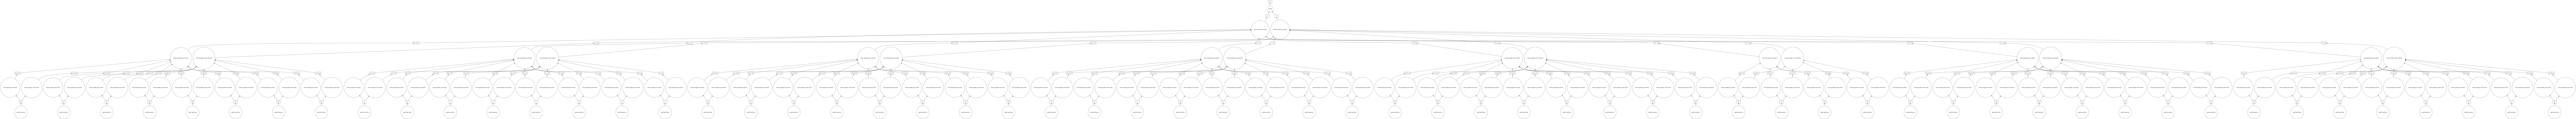

In [53]:
dask.visualize(result, optimize_graph=True)

In [55]:
# Now, we can finally compute the mean

result.compute()

name
Alice       0.000312
Bob        -0.001599
Charlie    -0.000489
Dan        -0.000820
Edith       0.000489
Frank      -0.000557
George      0.001156
Hannah      0.000240
Ingrid     -0.000582
Jerry       0.001189
Kevin      -0.001332
Laura      -0.000140
Michael    -0.000033
Norbert    -0.000360
Oliver     -0.000384
Patricia    0.000623
Quinn       0.000928
Ray         0.000297
Sarah       0.003028
Tim        -0.000938
Ursula      0.000937
Victor     -0.002734
Wendy      -0.001267
Xavier      0.001357
Yvonne     -0.000334
Zelda       0.000313
Name: x, dtype: float64

***
#### Now, application on output from a numerical simulation of a severe storm

#### <span style="color:blue">At 5.2 GB for each ensemble member + 4.2 GB for ENamean, total file size ~ 210 GB</span>

<span style="color:red">But can esily scale up if output frequency increased or additional variables written </span>

Using __Zarr__, we can alleviate the bottleneck of reading from disk; compression usually provides more effective bandwidth

> Zarr stores data in chunked, compressed, N-dimensional arrays

> Arrays can then be read/written concurrently to and from multiple threads or processes

In [56]:
# We are interested in all the analysis for all times rather than a single one. So, let's create a list of all files of interest
# NOTE: we are focusing on enmean files here

ens_mem = np.arange(1, 40, 1)
sim_time = np.arange(3900, 18000 + 300, 300)
# sim_time = np.delete(sim_time,np.where(sim_time == 12300))
fixed_str = "/scratch/rice/s/sharm261/Projects/051913_OK/ARPS/EnKF/1km243x243_3km153x153_051913_OK_SSEF/1km243x243_3km153x153_051913_OK_SSEF/"

# for individual ensemble members
files = [
    [
        fixed_str
        + f"EN0{str(x).zfill(2)}/ena0{str(x).zfill(2)}"
        + f".hdf0{str(y).zfill(5)}"
        for y in sim_time
    ]
    for x in ens_mem
]

# for enmean files only
# files = [fixed_str + f'ENamean/enmean.hdf0{str(x).zfill(5)}' for x in sim_time]

plotcontrolmodpath = "/depot/rtanama/users/sharm261/May_19_2013_all_stuff/python_scripts_ARPS_May_19_2013/2013May19enkf_new_workflow/plotCRM_control_ENamean_plots_1km243x243_3km153x153_051913_SSEF_KTLX_KVNX_KFDR_KCRI.py"
pc = utils.import_all_from(plotcontrolmodpath)

nproc_x = 3
nproc_y = 5

In [59]:
from dask.distributed import performance_report

with performance_report(filename="dask-report.html"):
    futures = [
        client.map(
            arps_read_xarray_cf,
            fs,
            [plotcontrolmodpath] * len(fs),
            [nproc_x] * len(fs),
            [nproc_y] * len(fs),
        )
        for fs in files
    ]

***

### Load ensemble mean saved as zarr objects using xarray

> xarray is a python library for analyzing large nd-arrays making use of associated metadata

`xarray introduces labels in the form of dimensions, coordinates, and attributes on top of raw NumPy`

`xarray is inspired by and borrows heavily from pandas, the popular data anlysis package focused on labelled tabular data`

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cf_xarray
xr.set_options(keep_attrs=True)

In [61]:
data = xr.open_zarr("../ARPS_output_zarr/zarr_enmean_output/enmean_KTLX_only/")
data = data.assign_coords({"z_left": np.arange(1, 51)})
data.cf.describe()

Axes:
	X: ['xc', 'xe']
	Y: ['yc', 'ye']
	Z: ['zc', 'zs', 'zsagl', 'zpagl', 'zp']
	T: ['time']

Coordinates:
	longitude: ['longitude']
	latitude: ['latitude']
	vertical: []
	time: ['time']

Cell Measures:
	area: unsupported
	volume: unsupported

Standard Names:
	['latitude', 'longitude', 'time']


In [62]:
# html repr for xarray datasets 

# Notice the representation of variables on an Arakawa C-staggered grid
# Data variables are dask array chunks
# auto-chunking or manual (here, it is smart enough to chunk along time dimension)

data

<xarray.Dataset>
Dimensions:      (time: 47, xc: 243, xe: 243, yc: 243, ye: 243, z_left: 50, zc: 53)
Coordinates:
    latitude     (yc) float64 dask.array<chunksize=(243,), meta=np.ndarray>
    longitude    (xc) float64 dask.array<chunksize=(243,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2013-05-19T20:05:00 ... 2013-05-20
  * xc           (xc) float32 -500.0 500.0 1500.0 ... 239500.0 240500.0 241000.0
  * xe           (xe) float32 -1000.0 0.0 1000.0 ... 239000.0 240000.0 241000.0
  * yc           (yc) float32 -500.0 500.0 1500.0 ... 239500.0 240500.0 241000.0
  * ye           (ye) float32 -1000.0 0.0 1000.0 ... 239000.0 240000.0 241000.0
  * zc           (zc) float32 -400.0 0.0 400.0 800.0 ... 19600.0 20000.0 20400.0
    zp           (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>
    zpagl        (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>
    zs           (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>
    zsagl        (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>
  * z_left       (z_left) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
Data variables:
    hor_div      (time, xc, yc, zc) float64 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    p            (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    precip_rate  (time, xc, yc) float32 dask.array<chunksize=(1, 243, 243), meta=np.ndarray>
    pt           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    pte          (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    ptr          (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    qc           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    qg           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    qh           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    qi           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    qr           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    qs           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    qv           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    u            (time, xe, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    us           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    v            (time, xc, ye, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    vs           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    w            (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
    ws           (time, xc, yc, zc) float32 dask.array<chunksize=(1, 243, 243, 53), meta=np.ndarray>
Attributes:
    conventions:  CF
    description:  ARPS model output

### Quick summary of data variables

In [63]:
# dask array indexing on time dimension

data.ptr.isel(time=17) # density potential temperature

<xarray.DataArray 'ptr' (xc: 243, yc: 243, zc: 53)>
dask.array<getitem, shape=(243, 243, 53), dtype=float32, chunksize=(243, 243, 53), chunktype=numpy.ndarray>
Coordinates:
    latitude   (yc) float64 dask.array<chunksize=(243,), meta=np.ndarray>
    longitude  (xc) float64 dask.array<chunksize=(243,), meta=np.ndarray>
    time       datetime64[ns] 2013-05-19T21:30:00
  * xc         (xc) float32 -500.0 500.0 1500.0 ... 239500.0 240500.0 241000.0
  * yc         (yc) float32 -500.0 500.0 1500.0 ... 239500.0 240500.0 241000.0
  * zc         (zc) float32 -400.0 0.0 400.0 800.0 ... 19600.0 20000.0 20400.0
    zp         (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>
    zpagl      (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>
    zs         (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>
    zsagl      (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>

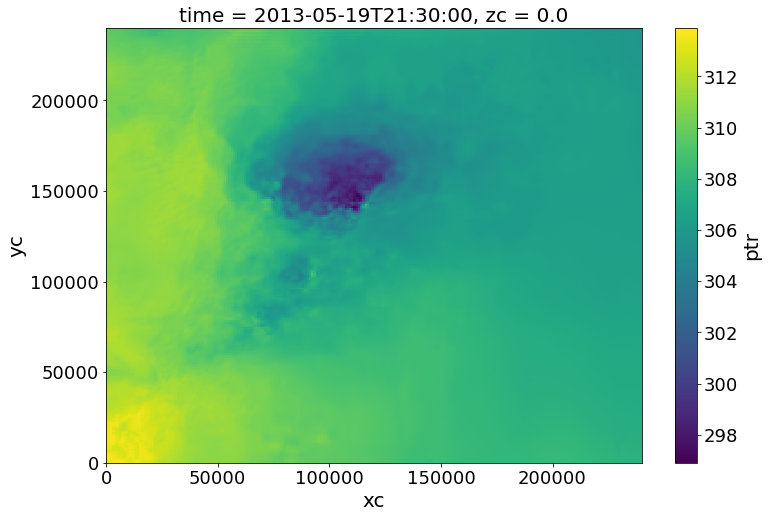

In [64]:
# Plot density potential temperature

data.ptr.isel(time=17,xc=slice(1,-2),yc=slice(1,-2),zc=1).T.plot()

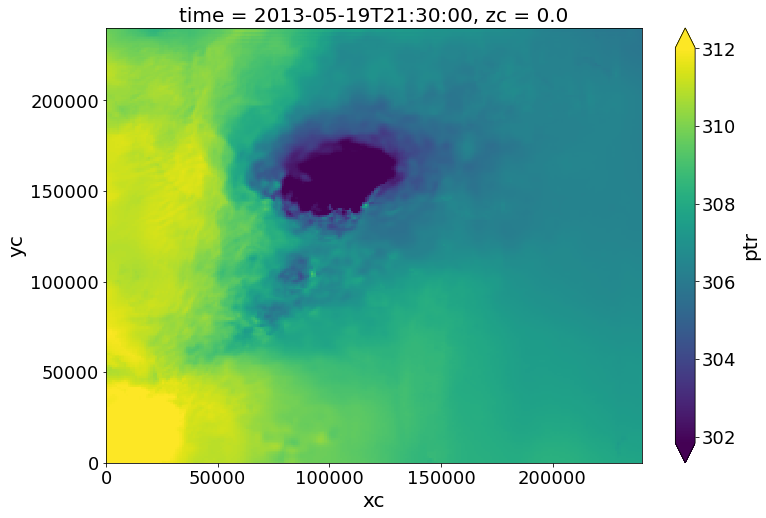

In [65]:
data.ptr.isel(time=17,xc=slice(1,-2),yc=slice(1,-2),zc=1).T.plot(robust=True)

In [66]:
data.ptr

<xarray.DataArray 'ptr' (time: 47, xc: 243, yc: 243, zc: 53)>
dask.array<zarr, shape=(47, 243, 243, 53), dtype=float32, chunksize=(1, 243, 243, 53), chunktype=numpy.ndarray>
Coordinates:
    latitude   (yc) float64 dask.array<chunksize=(243,), meta=np.ndarray>
    longitude  (xc) float64 dask.array<chunksize=(243,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2013-05-19T20:05:00 ... 2013-05-20
  * xc         (xc) float32 -500.0 500.0 1500.0 ... 239500.0 240500.0 241000.0
  * yc         (yc) float32 -500.0 500.0 1500.0 ... 239500.0 240500.0 241000.0
  * zc         (zc) float32 -400.0 0.0 400.0 800.0 ... 19600.0 20000.0 20400.0
    zp         (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>
    zpagl      (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>
    zs         (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>
    zsagl      (xc, yc, zc) float32 dask.array<chunksize=(243, 243, 53), meta=np.ndarray>

### Operations in label space

In [67]:
# Since enmean dataset opened above does not have a reflectivity field in itself, we plan to calculate mean reflectivity 
# from individual ensemble members and then add that averaged reflectivity to the enmean dataset

full_ens_data = xr.open_zarr('../ARPS_output_zarr/arps_full_zarr_dataset_KTLX_only/')
data['trefl'] = full_ens_data.groupby('time').mean(dim='time').trefl

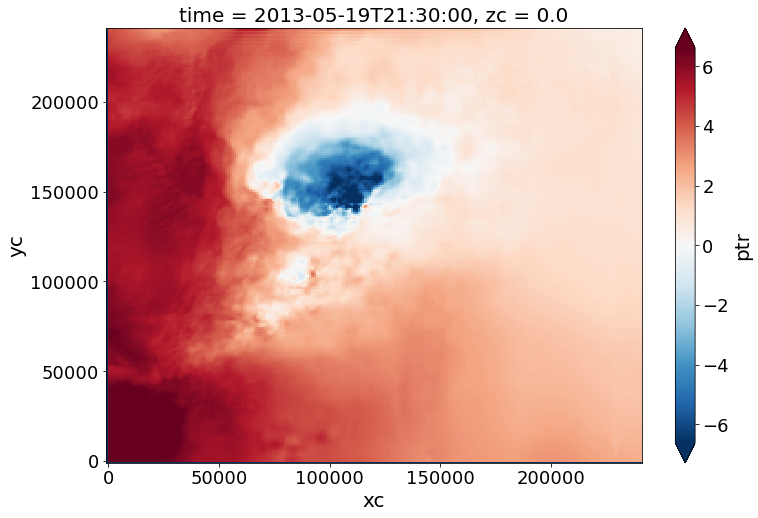

In [68]:
(data.ptr.isel(time=17,zc=1) - data.ptr.isel(time=17,zc=1).mean(['xc','yc'])).T.plot(robust=True)

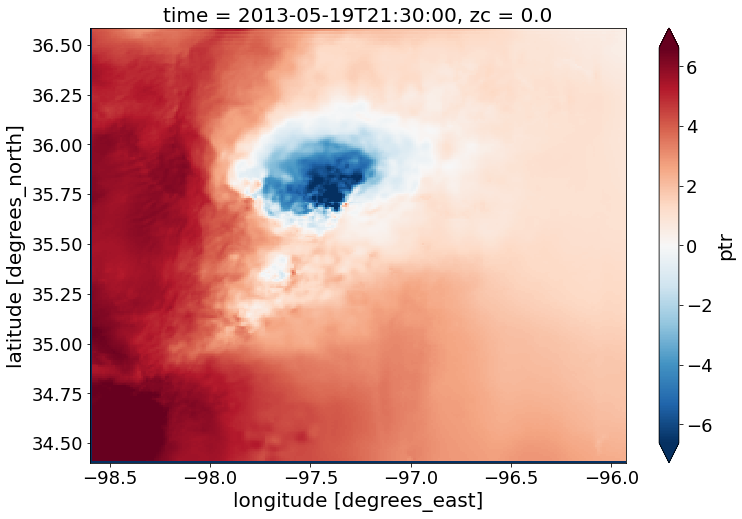

In [69]:
# use lat lon labels instead

(data.ptr.isel(time=17,zc=1) - data.ptr.isel(time=17,zc=1).mean(['xc','yc'])).T.plot(
                                                    x='longitude',y='latitude',robust=True)

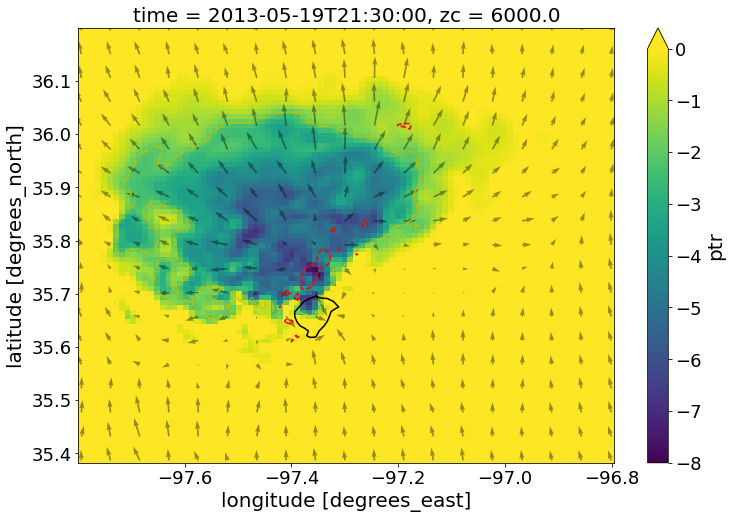

CPU times: user 1.69 s, sys: 165 ms, total: 1.85 s
Wall time: 4.99 s


In [70]:
%%time

from plot_coldpool import plot_coldpool_features_minptr_based

cp, trefl,x, y, z, u, v, w, div,xline,yline = plot_coldpool_features_minptr_based(data,'ptr',data.time[17])

fig,ax = plt.subplots()
cp.isel(zc=1).plot(x='longitude',y='latitude',ax=ax,vmin=-8,vmax=0)
#     div.plot(ax=ax,cmap=cmo.balance)
cs3 = cp.isel(zc=1).plot.contour(x='longitude',y='latitude',levels=[-2,],colors=['y'],linestyles ='-.')

ax.quiver(x.longitude[::5],y.latitude[::5],u.isel(zc=1)[::5,::5],v.isel(zc=1)[::5,::5],scale=500,alpha=0.4)
w.isel(zc=15).plot.contour(x='longitude',y='latitude',ax=ax,levels=[15],colors=['k'])
ax.contour(w.isel(zc=9).longitude, w.isel(zc=9).latitude,w.isel(zc=9),levels=[-5],colors=['red'],linestyles = '--')
plt.clabel(cs3, inline=1, fontsize=10)
plt.show()

### One plot is fine but what about the entire simulation?

In [71]:
dates = data.time

# store ws and cold pool dataarrays at each analysis time in a list
w_ts = []
cp_ts = []
trefl_ts = []
for date in dates:
    cp, trefl,x, y, z, u, v, w, div,xline,yline = plot_coldpool_features_minptr_based(data,'ptr',date)
    cp_ts.append(cp)
    w_ts.append(w)
    trefl_ts.append(trefl)

In [72]:
# First, let's merge all the times at which we have our cold pool datasets

cp_subdomain = xr.concat(cp_ts,dim='time')
ws_subdomain = xr.concat(w_ts,dim='time')
trefl_subdomain = xr.concat(trefl_ts,dim='time')

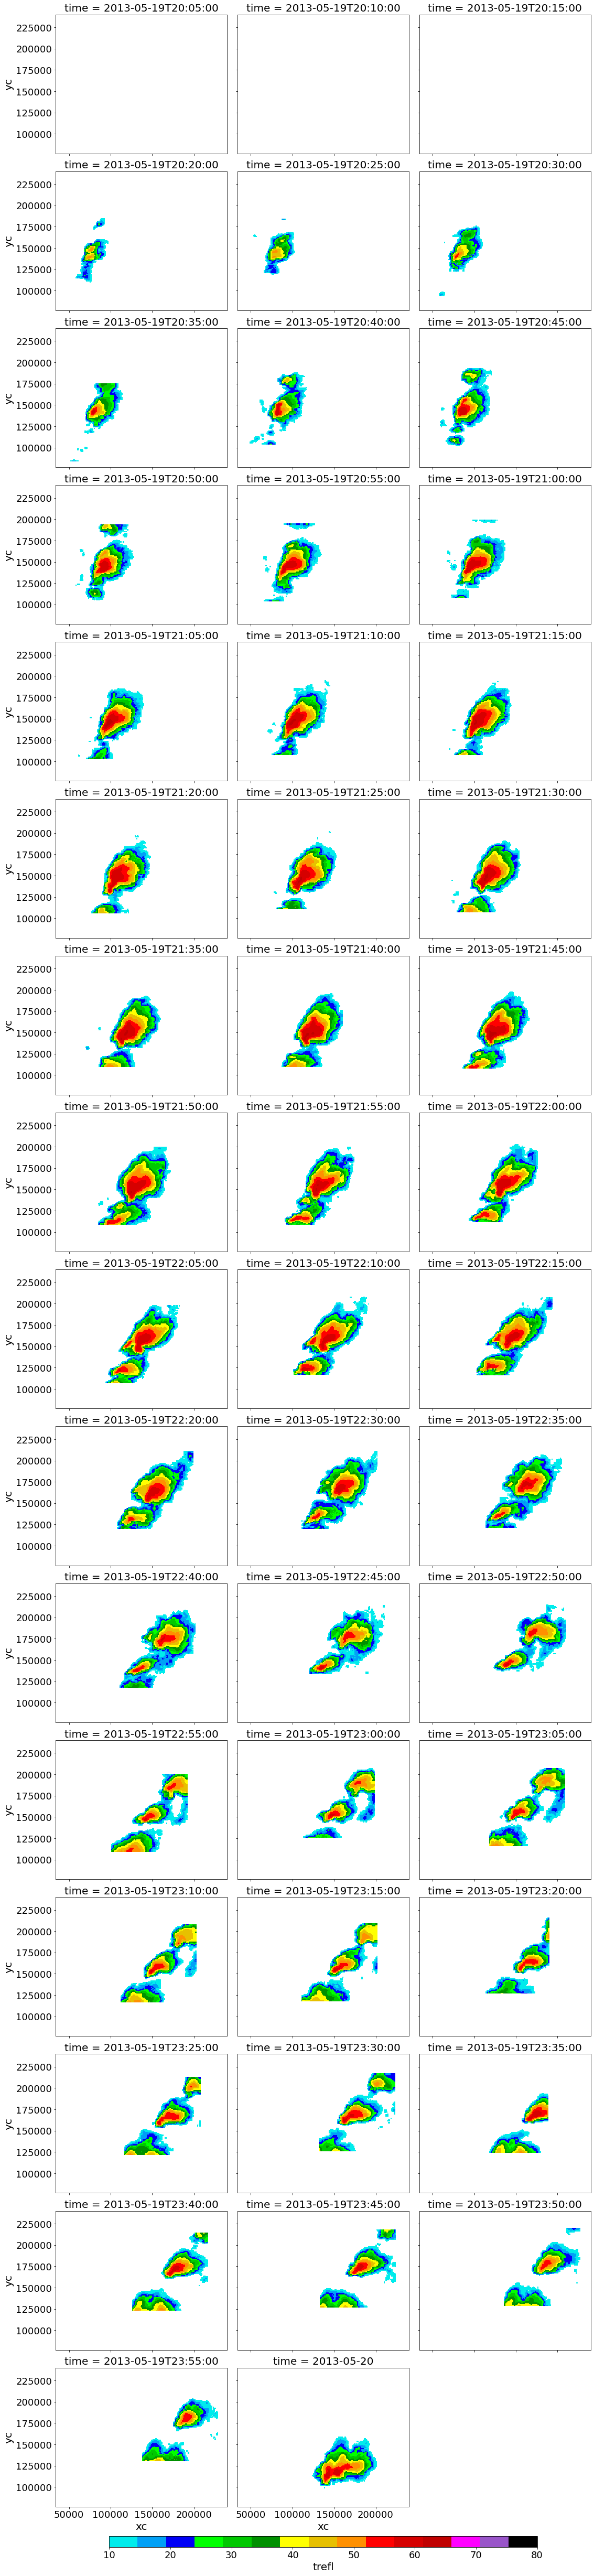

In [73]:
# Let's plot the same reflectivity field across all time steps in one go as a facetgrid plot

z_idx = 1
mean_dBZ = trefl_subdomain.where(trefl_subdomain>10)
mean_dBZ.isel(zc=z_idx).plot(col="time",col_wrap=3,cmap=pc.fieldcm,
                                                          vmin=10,vmax=80,aspect=1,size=5,
                                                        cbar_kwargs={"orientation":"horizontal",
                                                                       "shrink":0.8,
                                                                     "aspect":40,
                                                                    "pad":0.01})

## xarray + Dask + Numba

Numba: 
> An open-source, function-at-a-time compiler library for Python

> generates optimized machine code using LLVM

> specifically designed for math-heavy Python code
    
    Speedup: 2x (compared to basic NumPy code) to 200x (compared to pure Python) 

<p>
    <center><img style="float:center;" src="logos/numba_scipy2017.png"  width="1000"/></center>
</p>

In [85]:
# let's see the difference in computation time using regular numpy vs numba code

satfwa = 1.0007
satfwb = 3.46e-8
satewa = 611.21
satewb = 17.502
satewc = 32.18

Rd = 287.0
Rv = 461.0
cp = 1005.6
rddcp = Rd / cp
rddrv = Rd / Rv
p0 = 100000.0  # Reference pressure in Pa

from numba import vectorize
@vectorize(["float64(float64, float64, float64)"], nopython=True)
def calpte(p, pt, qv):
    """
    Calculate equivalent potential temperature based on Bolton's (1980) approximation
    from T, p, and qv.  Note, uses the calTd and calT functions defined previously.
    """
    # First, calculate temperature and dewpoint temperature
    
    # Calculate dewpoint temperature from pressure and water vapor specific humidity.
    # This uses the forumulae from Buck (1981, JAM) as used in ARPS thermolib3d.f90. """
    
    f = satfwa + satfwb * p

    # Calculate vapor pressure from pressure and water vapor specific humidity
    e = p * qv / (rddrv + (1.0 - rddrv) * qv)

    A = np.log(e / (satewa * f))

    Td = (satewc * A - 273.15 * satewb) / (A - satewb)
    T = pt * (p / p0)**rddcp

    # Calculate temperature at LCL

    Tl = 1.0 / ((1.0 / (Td - 56.)) + np.log(T / Td) / 800.0) + 56.0

    # Convert qv to water vapor mixing ratio
    w = qv / (1. - qv)

    # Finally compute theta_e

    pte = (T * (p0 / p)**(0.2854 * (1.0 - (0.28e-3) * 1000.0 * w))) * \
        np.exp((3.376 / Tl - 0.00254) * 1000.0 * w * (1.0 + (0.81e-3) * 1000.0 * w))

    return pte

In [86]:
def pot_tmp(p,pt,qv):
    return xr.apply_ufunc(
    calpte,
    p,
    pt,
    qv,       
    dask="parallelized",
    output_dtypes=[p.dtype]
    )

In [84]:
%time pot_tmp(data.isel(time=17).p,data.isel(time=17).pt,data.isel(time=17).qv).compute()

CPU times: user 747 ms, sys: 244 ms, total: 991 ms
Wall time: 729 ms


<xarray.DataArray (xc: 243, yc: 243, zc: 53)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [343.7886 , 343.98032, 344.126  , ...,       nan,       nan,
               nan],
        [343.72064, 343.90097, 344.06943, ...,       nan,       nan,
               nan],
...
        [363.75632, 363.83118, 363.8028 , ...,       nan,       nan,
               nan],
        [363.75632, 363.83115, 363.81546, ...,       nan,       nan,
               nan],
        [363.75632, 363.83115, 363.81546, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [335.63947, 335.70663, 335.69403, ...,       nan,       nan,
               nan],
        [335.62802, 335.6952 , 335.68256, ...,       nan,       nan,
               nan],
        ...,
        [363.75632, 363.83118, 363.8028 , ...,       nan,       nan,
               nan],
        [363.75632, 363.83115, 363.81546, ...,       nan,       nan,
               nan],
        [363.75632, 363.83115, 363.81546, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    latitude   (yc) float64 34.41 34.42 34.42 34.43 ... 36.56 36.57 36.58 36.58
    longitude  (xc) float64 -98.59 -98.58 -98.57 -98.56 ... -95.95 -95.94 -95.93
    time       datetime64[ns] 2013-05-19T21:30:00
  * xc         (xc) float32 -500.0 500.0 1500.0 ... 239500.0 240500.0 241000.0
  * yc         (yc) float32 -500.0 500.0 1500.0 ... 239500.0 240500.0 241000.0
  * zc         (zc) float32 -400.0 0.0 400.0 800.0 ... 19600.0 20000.0 20400.0
    zp         (xc, yc, zc) float32 0.0 0.0 0.0 ... 19219.996 20000.0 20780.004
    zpagl      (xc, yc, zc) float32 0.0 0.0 0.0 ... 19219.996 20000.0 20780.004
    zs         (xc, yc, zc) float32 0.0 0.0 0.0 ... 20390.002 21170.006
    zsagl      (xc, yc, zc) float32 0.0 0.0 0.0 ... 20390.002 21170.006

In [87]:
%time pot_tmp(data.isel(time=17).p,data.isel(time=17).pt,data.isel(time=17).qv).compute()

CPU times: user 336 ms, sys: 138 ms, total: 473 ms
Wall time: 285 ms


<xarray.DataArray (xc: 243, yc: 243, zc: 53)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [343.78861397, 343.98028086, 344.12600163, ...,          nan,
                  nan,          nan],
        [343.72069639, 343.9010378 , 344.06940723, ...,          nan,
                  nan,          nan],
...
        [363.7563479 , 363.83116134, 363.80280565, ...,          nan,
                  nan,          nan],
        [363.75630126, 363.83111468, 363.81547314, ...,          nan,
                  nan,          nan],
        [363.75630126, 363.83111468, 363.81547314, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [335.63944013, 335.70663542, 335.69399807, ...,          nan,
                  nan,          nan],
        [335.62801003, 335.69520528, 335.68253366, ...,          nan,
                  nan,          nan],
        ...,
        [363.7563479 , 363.83116134, 363.80280565, ...,          nan,
                  nan,          nan],
        [363.75630126, 363.83111468, 363.81547314, ...,          nan,
                  nan,          nan],
        [363.75630126, 363.83111468, 363.81547314, ...,          nan,
                  nan,          nan]]])
Coordinates:
    latitude   (yc) float64 34.41 34.42 34.42 34.43 ... 36.56 36.57 36.58 36.58
    longitude  (xc) float64 -98.59 -98.58 -98.57 -98.56 ... -95.95 -95.94 -95.93
    time       datetime64[ns] 2013-05-19T21:30:00
  * xc         (xc) float32 -500.0 500.0 1500.0 ... 239500.0 240500.0 241000.0
  * yc         (yc) float32 -500.0 500.0 1500.0 ... 239500.0 240500.0 241000.0
  * zc         (zc) float32 -400.0 0.0 400.0 800.0 ... 19600.0 20000.0 20400.0
    zp         (xc, yc, zc) float32 0.0 0.0 0.0 ... 19219.996 20000.0 20780.004
    zpagl      (xc, yc, zc) float32 0.0 0.0 0.0 ... 19219.996 20000.0 20780.004
    zs         (xc, yc, zc) float32 0.0 0.0 0.0 ... 20390.002 21170.006
    zsagl      (xc, yc, zc) float32 0.0 0.0 0.0 ... 20390.002 21170.006

#### Another example: Calculate horizontal divergence

In [88]:
from pyCRMtools.modules.arpsmodule import cal_hdiv
from pyCRMtools.pycaps import arps_read

cal_hdiv??

Signature: cal_hdiv(nx, ny, nz, dx, dy, u, v)
Source:   
def cal_hdiv(nx, ny, nz, dx, dy, u, v):
    """Given the horizontal wind components, compute the horizontal divergence."""

    hdiv = np.empty((nx, ny, nz))

    hdiv[:-1, :-1, :] = (u[1:, :-1, :] - u[:-1, :-1, :]) / dx + \
        (v[:-1, 1:, :] - v[:-1, :-1, :]) / dy

    return hdiv
File:      ~/pyCRMtools/pyCRMtools/modules/arpsmodule.py
Type:      function


In [89]:
var_list = ['u','v','w','p','pt','qv','qr','qi','qg','qh','qc','qs','totalrefl']

In [90]:
nx, ny, nz, dx, dy, dz, x, y, z, zp, xs, ys, zs, zpagl, zsagl = arps_read.readarpsgrid(files[0][17],nproc_x=nproc_x,nproc_y=nproc_y).values()
u,v,w,p,pt,qv,qr,qi,qg,qh,qc,qs,trefl = arps_read.hdfreadvars3d(files[0][17],var_list,nproc_x=nproc_x,nproc_y=nproc_y).values()

In [91]:
%time cal_hdiv(nx,ny,nz,dx,dy,u,v)

CPU times: user 27.8 ms, sys: 13.5 ms, total: 41.2 ms
Wall time: 37.4 ms


array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.63274992e-03,  6.63276622e-03,  9.26861819e-03, ...,
         -1.41275406e-03, -1.41275406e-03, -1.41275406e-03],
        [ 6.50399132e-03,  6.50400203e-03,  9.04996414e-03, ...,
         -1.37067481e-03, -1.37067481e-03, -1.37067481e-03],
        ...,
        [ 3.26343859e-03,  3.26343626e-03,  4.85518295e-03, ...,
          3.48643400e-03,  3.48643400e-03,  3.48643400e-03],
        [ 4.37918771e-03,  4.37916955e-03,  6.08589686e-03, ...,
          3.51286260e-03,  3.51286051e-03,  3.51286051e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 3.86597612e-03,  3.86596681e-03,  5.65622794e-03, ...,
         -9.25997330e-04, -9.25997330e-04, -9.25997330e-04],
        [ 5.87576651e-04,  5.87573973e-04,  8.20643909e-04, ...,
          6.26582187e-06,  6.26582187e

In [92]:
nx, ny, nz, dx, dy, dz, x, y, z, zp, xs, ys, zs, zpagl, zsagl = [dask.array.from_array(x) for x in arps_read.readarpsgrid(files[0][17],nproc_x=nproc_x,nproc_y=nproc_y).values()]
u,v,w,p,pt,qv,qr,qi,qg,qh,qc,qs,trefl = [dask.array.from_array(x) for x in arps_read.hdfreadvars3d(files[0][17],var_list,nproc_x=nproc_x,nproc_y=nproc_y).values()]

In [93]:
import dask.array as da
@da.as_gufunc(signature="(),(),(),(),(),(m,n,p),(m,n,p)->(m,n,p)", output_dtypes=float, vectorize=True)
def gucal_hdiv(nx, ny, nz, dx, dy, u, v):
    """Given the horizontal wind components, compute the horizontal divergence."""

    hdiv = np.empty((nx, ny, nz))

    hdiv[:-1, :-1, :] = (u[1:, :-1, :] - u[:-1, :-1, :]) / dx + \
        (v[:-1, 1:, :] - v[:-1, :-1, :]) / dy

    return hdiv

In [94]:
%time gucal_hdiv(nx,ny,nz,dx,dy,u,v)

CPU times: user 5.67 ms, sys: 0 ns, total: 5.67 ms
Wall time: 5.59 ms


dask.array<transpose, shape=(243, 243, 53), dtype=float64, chunksize=(243, 243, 53), chunktype=numpy.ndarray>

## More dask + numba: Working with individual vertical profils at all (lat, lon,time) is common

`@numba.vectorize is great for easily generalising a function that takes a single scalar input and returns a single scalar output to higher-rank tensors,`

`@numba.guvectorize generalises this further by allowing functions operating on lower-order tensors to operate on higher-order tensors`

In [96]:
from numba import guvectorize,float64

In [97]:
@guvectorize(
    [(float64[:], float64[:], float64[:]), (float64[:], float64[:], float64[:]),],
    "(i), (i) -> ()",
    nopython=True,
)
def _gufunc_cp_depth(b, z, out):
    out[:] = np.nan
    
    mask = ~np.isnan(b)
    b = b[mask]
    z = z[mask]
    
    if len(b) == 0:
        return

    min_cp = -3 

    for idx in range(len(b)):
        if b[idx] > min_cp:
            break

    if idx == 0:
        out[:] = np.nan
    else:
        ip = idx - 1
        out[:] = z[ip]
#     if b[idx] - b[ip] < 0:
#         ip = idx - 1
    
#     if np.abs(dbdz[idx] - dbdz[ip]) < 1e-10:
#         hmxl = z[ip]
#     else:
#         hmxl = z[ip] + np.abs(
#             (z[idx] - z[ip]) / (dbdz[idx] - dbdz[ip]) * (max_dbdz_surf - dbdz[ip])
#         )

    

def calc_cp_depth(cp):
    z = cp.cf["zp"]
    zdim = 'zc'
    return xr.apply_ufunc(
        _gufunc_cp_depth,
        cp,
        z,
        input_core_dims=[(zdim,), (zdim,)],
        dask="parallelized",
        output_dtypes=[z.dtype],
    )

In [98]:
subset = cp_subdomain.isel(time=17).sel(xc=145000, yc=110000, method="nearest")

computed = dask.compute(subset, calc_cp_depth(subset))

In [99]:
mapped = (
    cp_subdomain.chunk({'time':1}).map_blocks(calc_cp_depth)
)

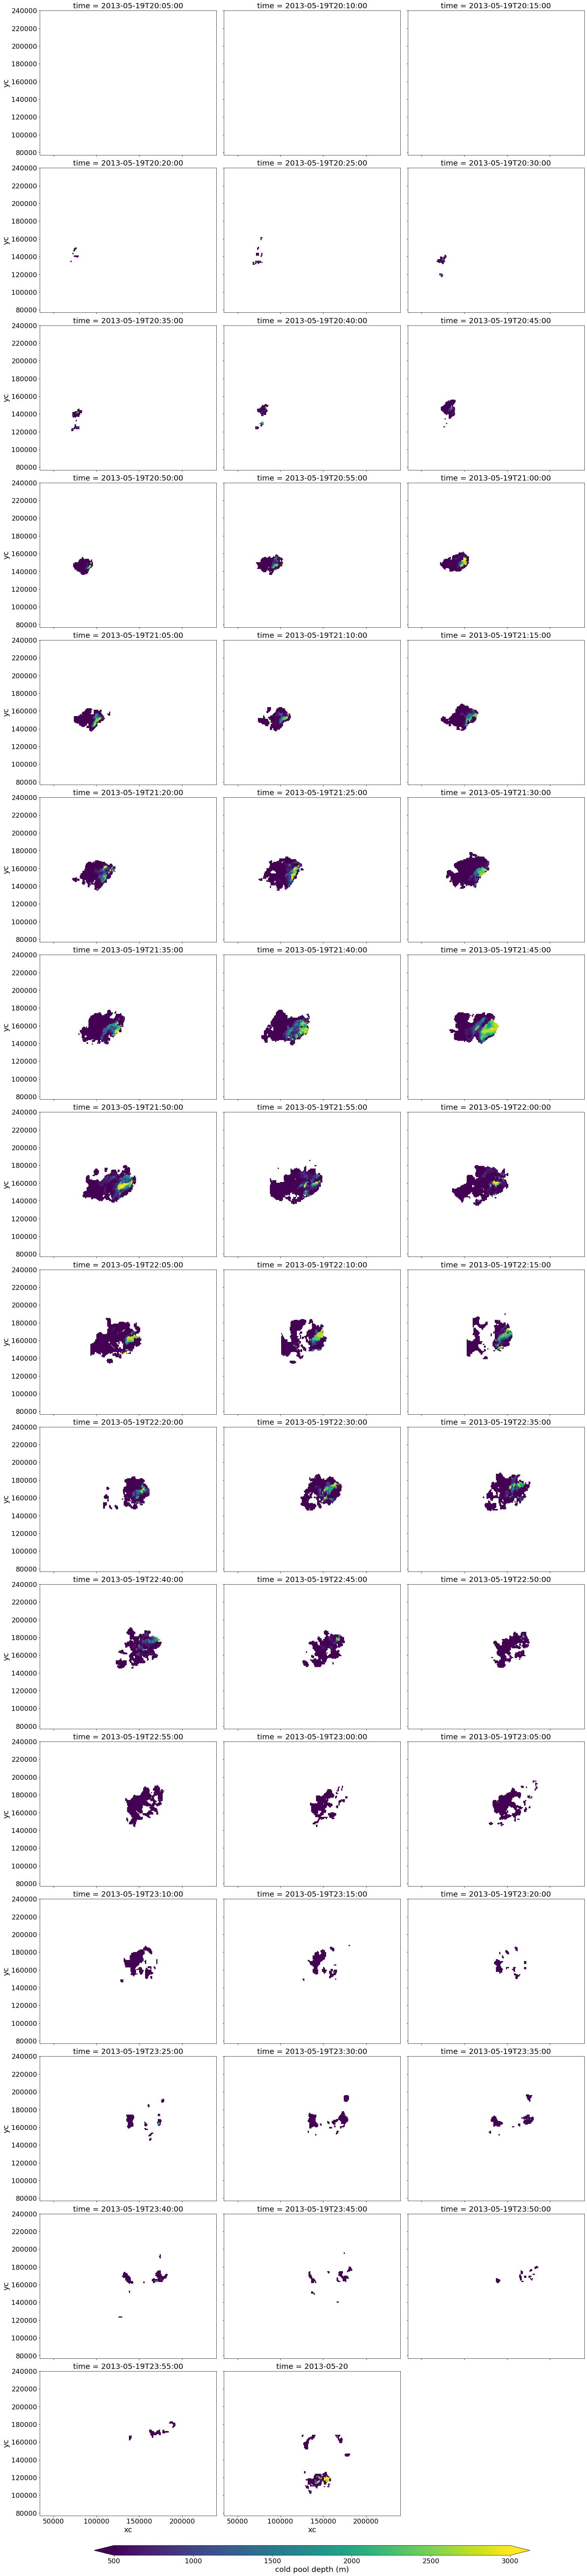

In [100]:
cp_depth = mapped.compute().cf.plot(col='time',col_wrap=3,aspect=1,size=7,
                         cbar_kwargs={"orientation":"horizontal",
                                               "shrink":0.8,
                                                "aspect":40,
                                               "pad":0.01,
                                               "label":'cold pool depth (m)'
                                     },
                        vmin=500,vmax=3000)

***

## References:

[Zarr documentation](https://zarr.readthedocs.io/en/stable/)

[Python and scalability](https://medium.com/@trungluongquang/is-python-really-scalable-90e0d028ba4a)

[JIT compilation in python](https://medium.com/starschema-blog/jit-fast-supercharge-tensor-processing-in-python-with-jit-compilation-47598de6ee96)

[All about python's GIL feature](https://realpython.com/python-gil/)

[Numpy universal functions (ufuncs)](https://numba.pydata.org/numba-doc/dev/user/vectorize.html)

[Numba guvectorize](https://numba.pydata.org/numba-doc/dev/reference/jit-compilation.html#numba.guvectorize)

[More on Numba's vectorize and guvectorize](https://tobiasraabe.github.io/blog/numba-vectorize-and-guvectorize.html)
